In [124]:
#import libraries
import pandas as pd;
import geopandas as gpd;
import matplotlib.pyplot as plt;
import numpy as np; #Using numpy for regex
import pgeocode; #Used to convert postcodes to locations
from shapely.geometry import Point; # Shapely for converting latitude/longtitude to geometry
import geopy.distance
from geopy.geocoders import Nominatim
import json;

import traveltimepy as ttpy
import os
from datetime import datetime #for examples
#TODO: store credentials in an environment variable
os.environ["TRAVELTIME_ID"] = '466b4c75'
os.environ["TRAVELTIME_KEY"] = 'aa473fed8d8638f1b576305a7e1fc019'


In [95]:
#Load Distribution Centre Data
df = pd.read_excel(r'DistributionCentres.xlsx', sheet_name='master')
df

Line                  Corp Name               Company Name  \
0     400                4PX Express             4PX Express UK   
1     572                4PX Express                4PX Express   
2     359      4PX Express UK Co Ltd      4PX Express UK Co Ltd   
3      94     A Steadman and Son Ltd     A Steadman and Son Ltd   
4     894  A.F.Blakemore and Son Ltd  A.F.Blakemore and Son Ltd   
..    ...                        ...                        ...   
901   461            Yusen Logistics            Yusen Logistics   
902   536            Yusen Logistics            Yusen Logistics   
903   578            Yusen Logistics            Yusen Logistics   
904   579            Yusen Logistics            Yusen Logistics   
905   137                 Zooplus AG                 Zooplus AG   

    Initial Target            Building Name        Address            City  \
0              NaN            Dunstable 240    Arenson Way       Dunstable   
1              NaN          Northampton 250      Weedon Rd     Northampton   
2              NaN            Leicester 335   Leicester Ln       Leicester   
3              NaN                Steadmans         Wanell        Carlisle   
4              NaN  A F Blakemore & Son Ltd       Longacre      Willenhall   
..             ...                      ...            ...             ...   
901            3PL             NYK Building  Bradbourne Dr   Milton Keynes   
902            3PL                      NaN     Cheaney Dr     Northampton   
903            3PL          Yusen Logistics  Rutherford Dr  Wellingborough   
904            3PL          Yusen Logistics      Sywell Rd  Wellingborough   
905            NaN               Carbon 207      Siskin Dr        Coventry   

              Region  PostCode PostCode Sector  ... SFO Category  \
0    East of England   LU5 4SB             LU5  ...      200-500   
1      East Midlands   NN7 3NF             NN7  ...      200-500   
2      East Midlands  LE19 1SA             LE1  ...      200-500   
3         North West   CA5 7HH             CA5  ...      200-500   
4      West Midlands  WV13 2JP             WV1  ...      200-500   
..               ...       ...             ...  ...          ...   
901       South East   MK7 8BN             MK7  ...      200-500   
902    East Midlands   NN4 5FB             NN4  ...      200-500   
903    East Midlands   NN8 6AQ             NN8  ...      200-500   
904    East Midlands   NN8 6BS             NN8  ...      200-500   
905    West Midlands   CV3 4FJ             CV3  ...      200-500   

    Bldg Size (k sq ft) SFO = Bldg # Emp  \
0             200-249.9        Yes     0   
1             200-249.9        Yes     0   
2          250 to 499.9        Yes     0   
3             200-249.9        Yes     0   
4             200-249.9        Yes     0   
..                  ...        ...   ...   
901        250 to 499.9        Yes     0   
902           200-249.9        Yes   200   
903        250 to 499.9        Yes   150   
904        250 to 499.9        Yes     0   
905           200-249.9        Yes     0   

                                        Industry Type  \
0    Professional, Scientific, and Technical Services   
1                      Transportation and Warehousing   
2                      Transportation and Warehousing   
3                                       Manufacturing   
4                                                 NaN   
..                                                ...   
901                    Transportation and Warehousing   
902  Professional, Scientific, and Technical Services   
903                    Transportation and Warehousing   
904                    Transportation and Warehousing   
905                                          Retailer   

                     Location                  Submarket  \
0            Main HQ Corp/LLC      West Bedfordshire Ind   
1             Single Location  Northamptonshire South In   
2                         NaN                  Blaby

In [96]:
#Set up Freightliner locations
data = [['Leeds', 53.7496, -1.5494], ['Doncaster', 53.497, -1.1821]]
data_longer = [['Leeds', 53.7496, -1.5494], ['Doncaster', 53.497, -1.1821], ['iPort', 53.4789813,-1.119209], ['Tinsley', 53.4011002,-1.3850275], ['Gascoigne Wood', 53.7780692,-1.2133953], ['Teesport', 54.602699,-1.1465941]]
  
# Create the pandas DataFrame
fl_locations = pd.DataFrame(data, columns=['Terminal', 'Lat', 'Long'])  
all_locations = pd.DataFrame(data_longer, columns=['Terminal', 'Lat', 'Long'])  

# creating a geometry column 
geometry = [Point(xy) for xy in zip(fl_locations['Long'], fl_locations['Lat'])]
geometry_all = [Point(xy) for xy in zip(all_locations['Long'], all_locations['Lat'])]

# Coordinate reference system : WGS84
#crs = {'init': 'epsg:4326'}
crs = 'epsg:4326'
# Creating a Geographic data frame 
fl_points = gpd.GeoDataFrame(fl_locations, crs=crs, geometry=geometry)
all_points = gpd.GeoDataFrame(all_locations, crs=crs, geometry=geometry_all)

indexed_fl_points = fl_points.set_index('Terminal')
indexed_all_points = all_points.set_index('Terminal')
indexed_all_points

Lat      Long                   geometry
Terminal                                                      
Leeds           53.749600 -1.549400  POINT (-1.54940 53.74960)
Doncaster       53.497000 -1.182100  POINT (-1.18210 53.49700)
iPort           53.478981 -1.119209  POINT (-1.11921 53.47898)
Tinsley         53.401100 -1.385028  POINT (-1.38503 53.40110)
Gascoigne Wood  53.778069 -1.213395  POINT (-1.21340 53.77807)
Teesport        54.602699 -1.146594  POINT (-1.14659 54.60270)

In [150]:
#Inclusion & Exclusion Criteria

slice = df.rename(columns={'SFO (m)': 'sf_occupied_million', 'PostCode Sector': 'PostCode_District', 'PostCode Area': 'PostCode_Area'})
slice

Line                  Corp Name               Company Name  \
0     400                4PX Express             4PX Express UK   
1     572                4PX Express                4PX Express   
2     359      4PX Express UK Co Ltd      4PX Express UK Co Ltd   
3      94     A Steadman and Son Ltd     A Steadman and Son Ltd   
4     894  A.F.Blakemore and Son Ltd  A.F.Blakemore and Son Ltd   
..    ...                        ...                        ...   
901   461            Yusen Logistics            Yusen Logistics   
902   536            Yusen Logistics            Yusen Logistics   
903   578            Yusen Logistics            Yusen Logistics   
904   579            Yusen Logistics            Yusen Logistics   
905   137                 Zooplus AG                 Zooplus AG   

    Initial Target            Building Name        Address            City  \
0              NaN            Dunstable 240    Arenson Way       Dunstable   
1              NaN          Northampton 250      Weedon Rd     Northampton   
2              NaN            Leicester 335   Leicester Ln       Leicester   
3              NaN                Steadmans         Wanell        Carlisle   
4              NaN  A F Blakemore & Son Ltd       Longacre      Willenhall   
..             ...                      ...            ...             ...   
901            3PL             NYK Building  Bradbourne Dr   Milton Keynes   
902            3PL                      NaN     Cheaney Dr     Northampton   
903            3PL          Yusen Logistics  Rutherford Dr  Wellingborough   
904            3PL          Yusen Logistics      Sywell Rd  Wellingborough   
905            NaN               Carbon 207      Siskin Dr        Coventry   

              Region  PostCode PostCode_District  ... SFO Category  \
0    East of England   LU5 4SB               LU5  ...      200-500   
1      East Midlands   NN7 3NF               NN7  ...      200-500   
2      East Midlands  LE19 1SA               LE1  ...      200-500   
3         North West   CA5 7HH               CA5  ...      200-500   
4      West Midlands  WV13 2JP               WV1  ...      200-500   
..               ...       ...               ...  ...          ...   
901       South East   MK7 8BN               MK7  ...      200-500   
902    East Midlands   NN4 5FB               NN4  ...      200-500   
903    East Midlands   NN8 6AQ               NN8  ...      200-500   
904    East Midlands   NN8 6BS               NN8  ...      200-500   
905    West Midlands   CV3 4FJ               CV3  ...      200-500   

    Bldg Size (k sq ft) SFO = Bldg # Emp  \
0             200-249.9        Yes     0   
1             200-249.9        Yes     0   
2          250 to 499.9        Yes     0   
3             200-249.9        Yes     0   
4             200-249.9        Yes     0   
..                  ...        ...   ...   
901        250 to 499.9        Yes     0   
902           200-249.9        Yes   200   
903        250 to 499.9        Yes   150   
904        250 to 499.9        Yes     0   
905           200-249.9        Yes     0   

                                        Industry Type  \
0    Professional, Scientific, and Technical Services   
1                      Transportation and Warehousing   
2                      Transportation and Warehousing   
3                                       Manufacturing   
4                                                 NaN   
..                                                ...   
901                    Transportation and Warehousing   
902  Professional, Scientific, and Technical Services   
903                    Transportation and Warehousing   
904                    Transportation and Warehousing   
905                                          Retailer   

                     Location                  Submarket  \
0            Main HQ Corp/LLC      West Bedfordshire Ind   
1             Single Location  Northamptonshire South In   
2                         Na

In [160]:
slice[slice['PostCode_District'].str.contains('DN8')]

Line  Corp Name Company Name Initial Target Building Name  \
794   264  The Range    The Range         Retail  The Range UK   

               Address       City              Region PostCode  \
794  Mount Pleasant Rd  Doncaster  Yorkshire / Humber  DN8 4HT   

    PostCode_District  ... SFO Category Bldg Size (k sq ft) SFO = Bldg # Emp  \
794               DN8  ...     500-1000        500 to 999.9        Yes     0   

     Industry Type            Location      Submarket         Web Address  \
794     Wholesaler  Warehouse Corp/LLC  Doncaster Ind  www.therange.co.uk   

    Unnamed: 31 Unnamed: 32  
794         NaN         NaN  

[1 rows x 33 columns]

In [128]:
leeds_search = {
  'id': "Leeds",
  'departure_time':  "2022-10-11T09:00:00Z",
  'travel_time': 59*60,
  'coords': {'lat': indexed_all_points.loc["Leeds"]["Lat"], 'lng': indexed_all_points.loc["Leeds"]["Long"]},
  'transportation': {'type': "driving"},
  'properties': ["travel_time_all"],
  "reachable_postcodes_threshold": 0.1
}


leeds_data = ttpy.time_filter_postcode_districts(departure_searches=leeds_search)

{'results': [{'search_id': 'Leeds',
   'districts': [{'code': 'ls10',
     'properties': {'travel_time_all': {'min': 70,
       'max': 1037,
       'mean': 462,
       'median': 393}}},
    {'code': 'dn8',
     'properties': {'travel_time_all': {'min': 2438,
       'max': 2972,
       'mean': 2646,
       'median': 2656}}},
    {'code': 'yo8',
     'properties': {'travel_time_all': {'min': 2016,
       'max': 3506,
       'mean': 2662,
       'median': 2652}}},
    {'code': 'hx6',
     'properties': {'travel_time_all': {'min': 2198,
       'max': 2807,
       'mean': 2466,
       'median': 2441}}},
    {'code': 'm7',
     'properties': {'travel_time_all': {'min': 3001,
       'max': 3695,
       'mean': 3297,
       'median': 3288}}},
    {'code': 's66',
     'properties': {'travel_time_all': {'min': 2777,
       'max': 3450,
       'mean': 3138,
       'median': 3157}}},
    {'code': 'bl3',
     'properties': {'travel_time_all': {'min': 3229,
       'max': 3871,
       'mean': 3605,
 

In [158]:
doncaster_search = {
  'id': "Doncaster",
  'departure_time':  "2022-10-11T09:00:00Z",
  'travel_time': 59*60,
  'coords': {'lat': indexed_all_points.loc["Doncaster"]["Lat"], 'lng': indexed_all_points.loc["Doncaster"]["Long"]},
  'transportation': {'type': "driving"},
  'properties': ["travel_time_all"],
  "reachable_postcodes_threshold": 0.1
}


doncaster_data = ttpy.time_filter_postcode_districts(departure_searches=doncaster_search)

In [155]:
pcarea_tt = []
mean_tt = []
for pcarea in leeds_data.get('results')[0].get('districts'):
    pcarea_tt.append(pcarea.get('code'))
    mean_tt.append(pcarea.get('properties').get('travel_time_all').get('mean'))
    
output_tt = pd.DataFrame(list(zip(pcarea_tt, mean_tt)),
               columns =['pc_area', 'mean_tt'])
output_tt['pc_area'] = output_tt['pc_area'].str.upper()
output_tt

pc_area  mean_tt
0      LS10      462
1       DN8     2646
2       YO8     2662
3       HX6     2466
4        M7     3297
..      ...      ...
225      M5     3590
226     WF2     1393
227    LS15     1541
228     S25     3157
229     BD6     1601

[230 rows x 2 columns]

In [157]:
df2 = slice.merge(output_tt, left_on='PostCode_District', right_on='pc_area', how='left')
df2['mean_tt'].fillna(100000, inplace=True)
df2['Leeds_tt'] = df2['mean_tt']
df2.drop(columns=['pc_area', 'mean_tt'], inplace=True)
df2

Line                  Corp Name               Company Name  \
0     400                4PX Express             4PX Express UK   
1     572                4PX Express                4PX Express   
2     359      4PX Express UK Co Ltd      4PX Express UK Co Ltd   
3      94     A Steadman and Son Ltd     A Steadman and Son Ltd   
4     894  A.F.Blakemore and Son Ltd  A.F.Blakemore and Son Ltd   
..    ...                        ...                        ...   
901   461            Yusen Logistics            Yusen Logistics   
902   536            Yusen Logistics            Yusen Logistics   
903   578            Yusen Logistics            Yusen Logistics   
904   579            Yusen Logistics            Yusen Logistics   
905   137                 Zooplus AG                 Zooplus AG   

    Initial Target            Building Name        Address            City  \
0              NaN            Dunstable 240    Arenson Way       Dunstable   
1              NaN          Northampton 250      Weedon Rd     Northampton   
2              NaN            Leicester 335   Leicester Ln       Leicester   
3              NaN                Steadmans         Wanell        Carlisle   
4              NaN  A F Blakemore & Son Ltd       Longacre      Willenhall   
..             ...                      ...            ...             ...   
901            3PL             NYK Building  Bradbourne Dr   Milton Keynes   
902            3PL                      NaN     Cheaney Dr     Northampton   
903            3PL          Yusen Logistics  Rutherford Dr  Wellingborough   
904            3PL          Yusen Logistics      Sywell Rd  Wellingborough   
905            NaN               Carbon 207      Siskin Dr        Coventry   

              Region  PostCode PostCode_District  ... Bldg Size (k sq ft)  \
0    East of England   LU5 4SB               LU5  ...           200-249.9   
1      East Midlands   NN7 3NF               NN7  ...           200-249.9   
2      East Midlands  LE19 1SA               LE1  ...        250 to 499.9   
3         North West   CA5 7HH               CA5  ...           200-249.9   
4      West Midlands  WV13 2JP               WV1  ...           200-249.9   
..               ...       ...               ...  ...                 ...   
901       South East   MK7 8BN               MK7  ...        250 to 499.9   
902    East Midlands   NN4 5FB               NN4  ...           200-249.9   
903    East Midlands   NN8 6AQ               NN8  ...        250 to 499.9   
904    East Midlands   NN8 6BS               NN8  ...        250 to 499.9   
905    West Midlands   CV3 4FJ               CV3  ...           200-249.9   

    SFO = Bldg # Emp                                     Industry Type  \
0          Yes     0  Professional, Scientific, and Technical Services   
1          Yes     0                    Transportation and Warehousing   
2          Yes     0                    Transportation and Warehousing   
3          Yes     0                                     Manufacturing   
4          Yes     0                                               NaN   
..         ...   ...                                               ...   
901        Yes     0                    Transportation and Warehousing   
902        Yes   200  Professional, Scientific, and Technical Services   
903        Yes   150                    Transportation and Warehousing   
904        Yes     0                    Transportation and Warehousing   
905        Yes     0                                          Retailer   

                     Location                  Submarket  \
0            Main HQ Corp/LLC      West Bedfordshire Ind   
1             Single Location  Northamptonshire South In   
2                         NaN                  Blaby Ind   
3                     Main HQ              Allerdale Ind   
4               Divisional HQ                Walsall Ind   
..                        ...                        ...   
901                       NaN

#This code snippet was to get geocode data from Postcodes. Not needed anymore with TravelTime API

#geolocator = Nominatim(timeout=10, user_agent='PDS')
#test = df
#test['geocode'] = test['PostCode'].apply(lambda x: geolocator.geocode(x))


#TODO: This is old code for crow flies distance. To be converted to travel time

locs = indexed_all_points
locs['coords'] = list(zip(locs.Lat, locs.Long))
locs['coords']

test['latitude'] = [g.latitude for g in test.geocode]
test['Leeds_new'] = test['geocode'].apply(lambda x: geopy.distance.geodesic((x.latitude, x.longitude), locs.loc["Leeds"]["coords"]).miles if x not None else -1)

test['Leeds'] = test['coords'].apply(lambda x: geopy.distance.geodesic(x, locs.loc["Leeds"]["coords"]).miles)
test['Doncaster'] = test['coords'].apply(lambda x: geopy.distance.geodesic(x, locs.loc["Doncaster"]["coords"]).miles)
test['iPort'] = test['coords'].apply(lambda x: geopy.distance.geodesic(x, locs.loc["iPort"]["coords"]).miles)
test['Tinsley'] = test['coords'].apply(lambda x: geopy.distance.geodesic(x, locs.loc["Tinsley"]["coords"]).miles)
test['Gascoigne Wood'] = test['coords'].apply(lambda x: geopy.distance.geodesic(x, locs.loc["Gascoigne Wood"]["coords"]).miles)
test['Teesport'] = test['coords'].apply(lambda x: geopy.distance.geodesic(x, locs.loc["Teesport"]["coords"]).miles)
test


#Code snippet to count msf of distribution centre space within 50 mile crow flies of each option
distance = 50
summary = [['Leeds', test[test['Leeds'] < distance]['SFO (m)'].sum()], \
           ['Doncaster', test[test['Doncaster'] < distance]['SFO (m)'].sum()], \
           ['iPort', test[test['iPort'] < distance]['SFO (m)'].sum()], \
           ['Tinsley', test[test['Tinsley'] < distance]['SFO (m)'].sum()], \
           ['Gascoigne Wood', test[test['Gascoigne Wood'] < distance]['SFO (m)'].sum()], \
           ['Teesport', test[test['Teesport'] < distance]['SFO (m)'].sum()], \
           ['Ferrybridge', test[test['Ferrybridge'] < distance]['SFO (m)'].sum()]]
overview = pd.DataFrame(summary, columns=['Terminal', 'SF_within_distance']) 
overview

In [ ]:
test[test['geocode'].apply(lambda x: x is None)]

In [ ]:
leedsLocation = geolocator.geocode('WA7 1SE')
leedsLocation

# Postcode District Level Analysis (e.g., LN10)

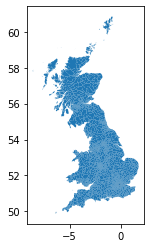

In [8]:
#Load and check map of PostCode Districts
fp = "postcodes/Districts.shp"
map_df = gpd.read_file(fp)
map_df.plot()

In [9]:
#Examine Header data of map
map_df.head()

name                                           geometry
0  AB10  POLYGON ((-2.11645 57.14656, -2.11655 57.14663...
1  AB11  MULTIPOLYGON (((-2.05257 57.13426, -2.05729 57...
2  AB12  MULTIPOLYGON (((-2.12807 57.03684, -2.12986 57...
3  AB13  POLYGON ((-2.26153 57.10694, -2.27015 57.11525...
4  AB14  POLYGON ((-2.26153 57.10694, -2.26315 57.10619...

In [10]:
#Aggregate postcodes with total containers for the year
aggregate_district = slice.groupby(["PostCode_District"])["sf_occupied_million"].sum().reset_index()
sorted_area = aggregate_district.sort_values(by = "sf_occupied_million", ascending = 0).head(20)
sorted_area
#sorted_area['SFO_pct'] = sorted_area.sf_occupied_million / df.sf_occupied_million.sum()
#sorted_area.style.format({
#    'Unit_pct': '{:,.1%}'.format,
#})


PostCode_District  sf_occupied_million
176               NN1            12.989568
130               LE1             9.140159
81                DN1             8.411538
180               NN6             7.179886
240               SN3             6.964650
179               NN4             6.779628
73                DE7             6.752037
68                DE1             6.746793
159               MK4             6.499566
158               MK1             6.349734
268               WA1             5.649176
34                BS3             5.283397
132               LE6             5.191193
54                CV2             5.077215
191               OL1             4.958489
65                DA1             4.782704
250               ST4             4.434589
215               RM1             4.277268
290               WS1             4.216954
170               NG1             4.193179

In [11]:
reset_index = map_df.set_index("name")
merged = reset_index.join(aggregate_district.set_index("PostCode_District"))
merged["sf_occupied_million"] = merged["sf_occupied_million"].fillna(0)
merged

geometry  sf_occupied_million
name                                                                        
AB10  POLYGON ((-2.11645 57.14656, -2.11655 57.14663...                  0.0
AB11  MULTIPOLYGON (((-2.05257 57.13426, -2.05729 57...                  0.0
AB12  MULTIPOLYGON (((-2.12807 57.03684, -2.12986 57...                  0.0
AB13  POLYGON ((-2.26153 57.10694, -2.27015 57.11525...                  0.0
AB14  POLYGON ((-2.26153 57.10694, -2.26315 57.10619...                  0.0
...                                                 ...                  ...
YO90  MULTIPOLYGON (((-1.08958 53.95931, -1.08891 53...                  0.0
YO91  POLYGON ((-1.06530 53.97796, -1.06634 53.97830...                  0.0
ZE1   MULTIPOLYGON (((-1.17282 60.12108, -1.18797 60...                  0.0
ZE2   MULTIPOLYGON (((-0.80210 60.40932, -0.80233 60...                  0.0
ZE3   MULTIPOLYGON (((-1.38060 59.88701, -1.37423 59...                  0.0

[2880 rows x 2 columns]

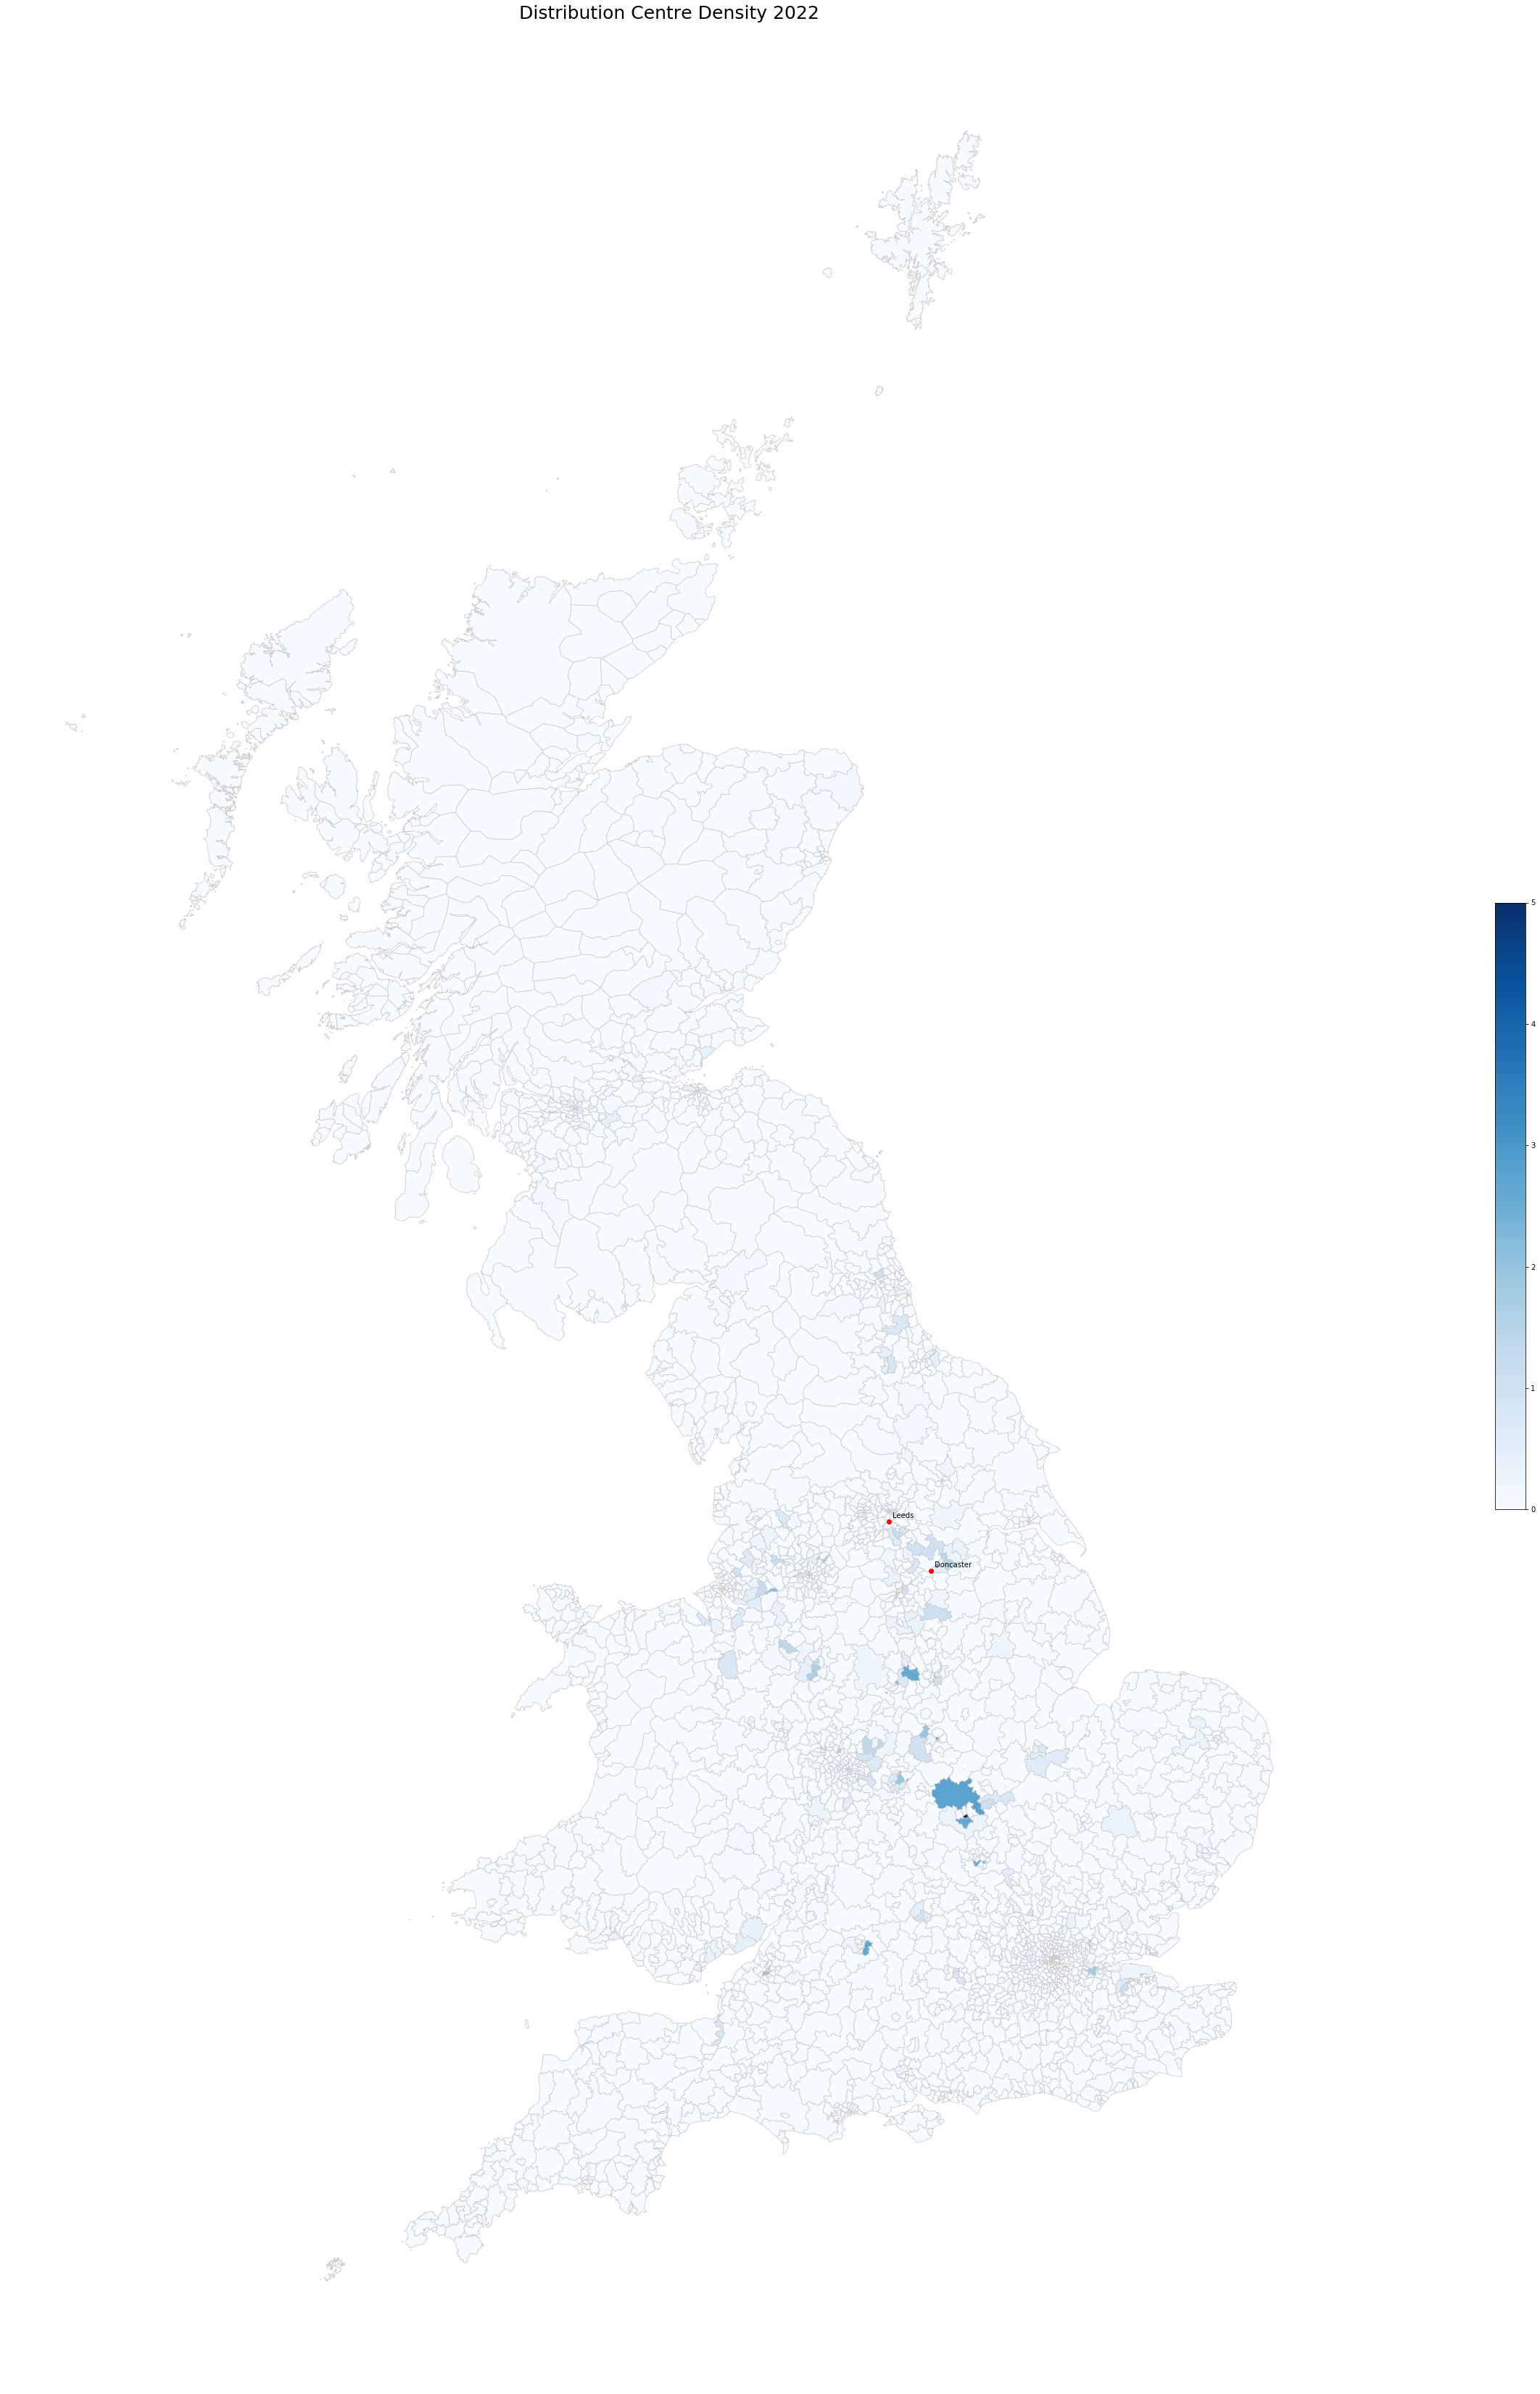

In [12]:
variable = "sf_occupied_million"
vmin, vmax = 0, 5
fig, ax = plt.subplots(1, figsize=(100, 60))

# add a title and remove axis
ax.set_title("Distribution Centre Density 2022", fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.axis('off')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, fraction=0.0075, pad=0.04)


ax.annotate("Leeds", (indexed_fl_points.loc["Leeds"]["Long"], indexed_fl_points.loc["Leeds"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax.annotate("Doncaster", (indexed_fl_points.loc["Doncaster"]["Long"], indexed_fl_points.loc["Doncaster"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")


merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
fl_points.plot(ax=ax, color="red")



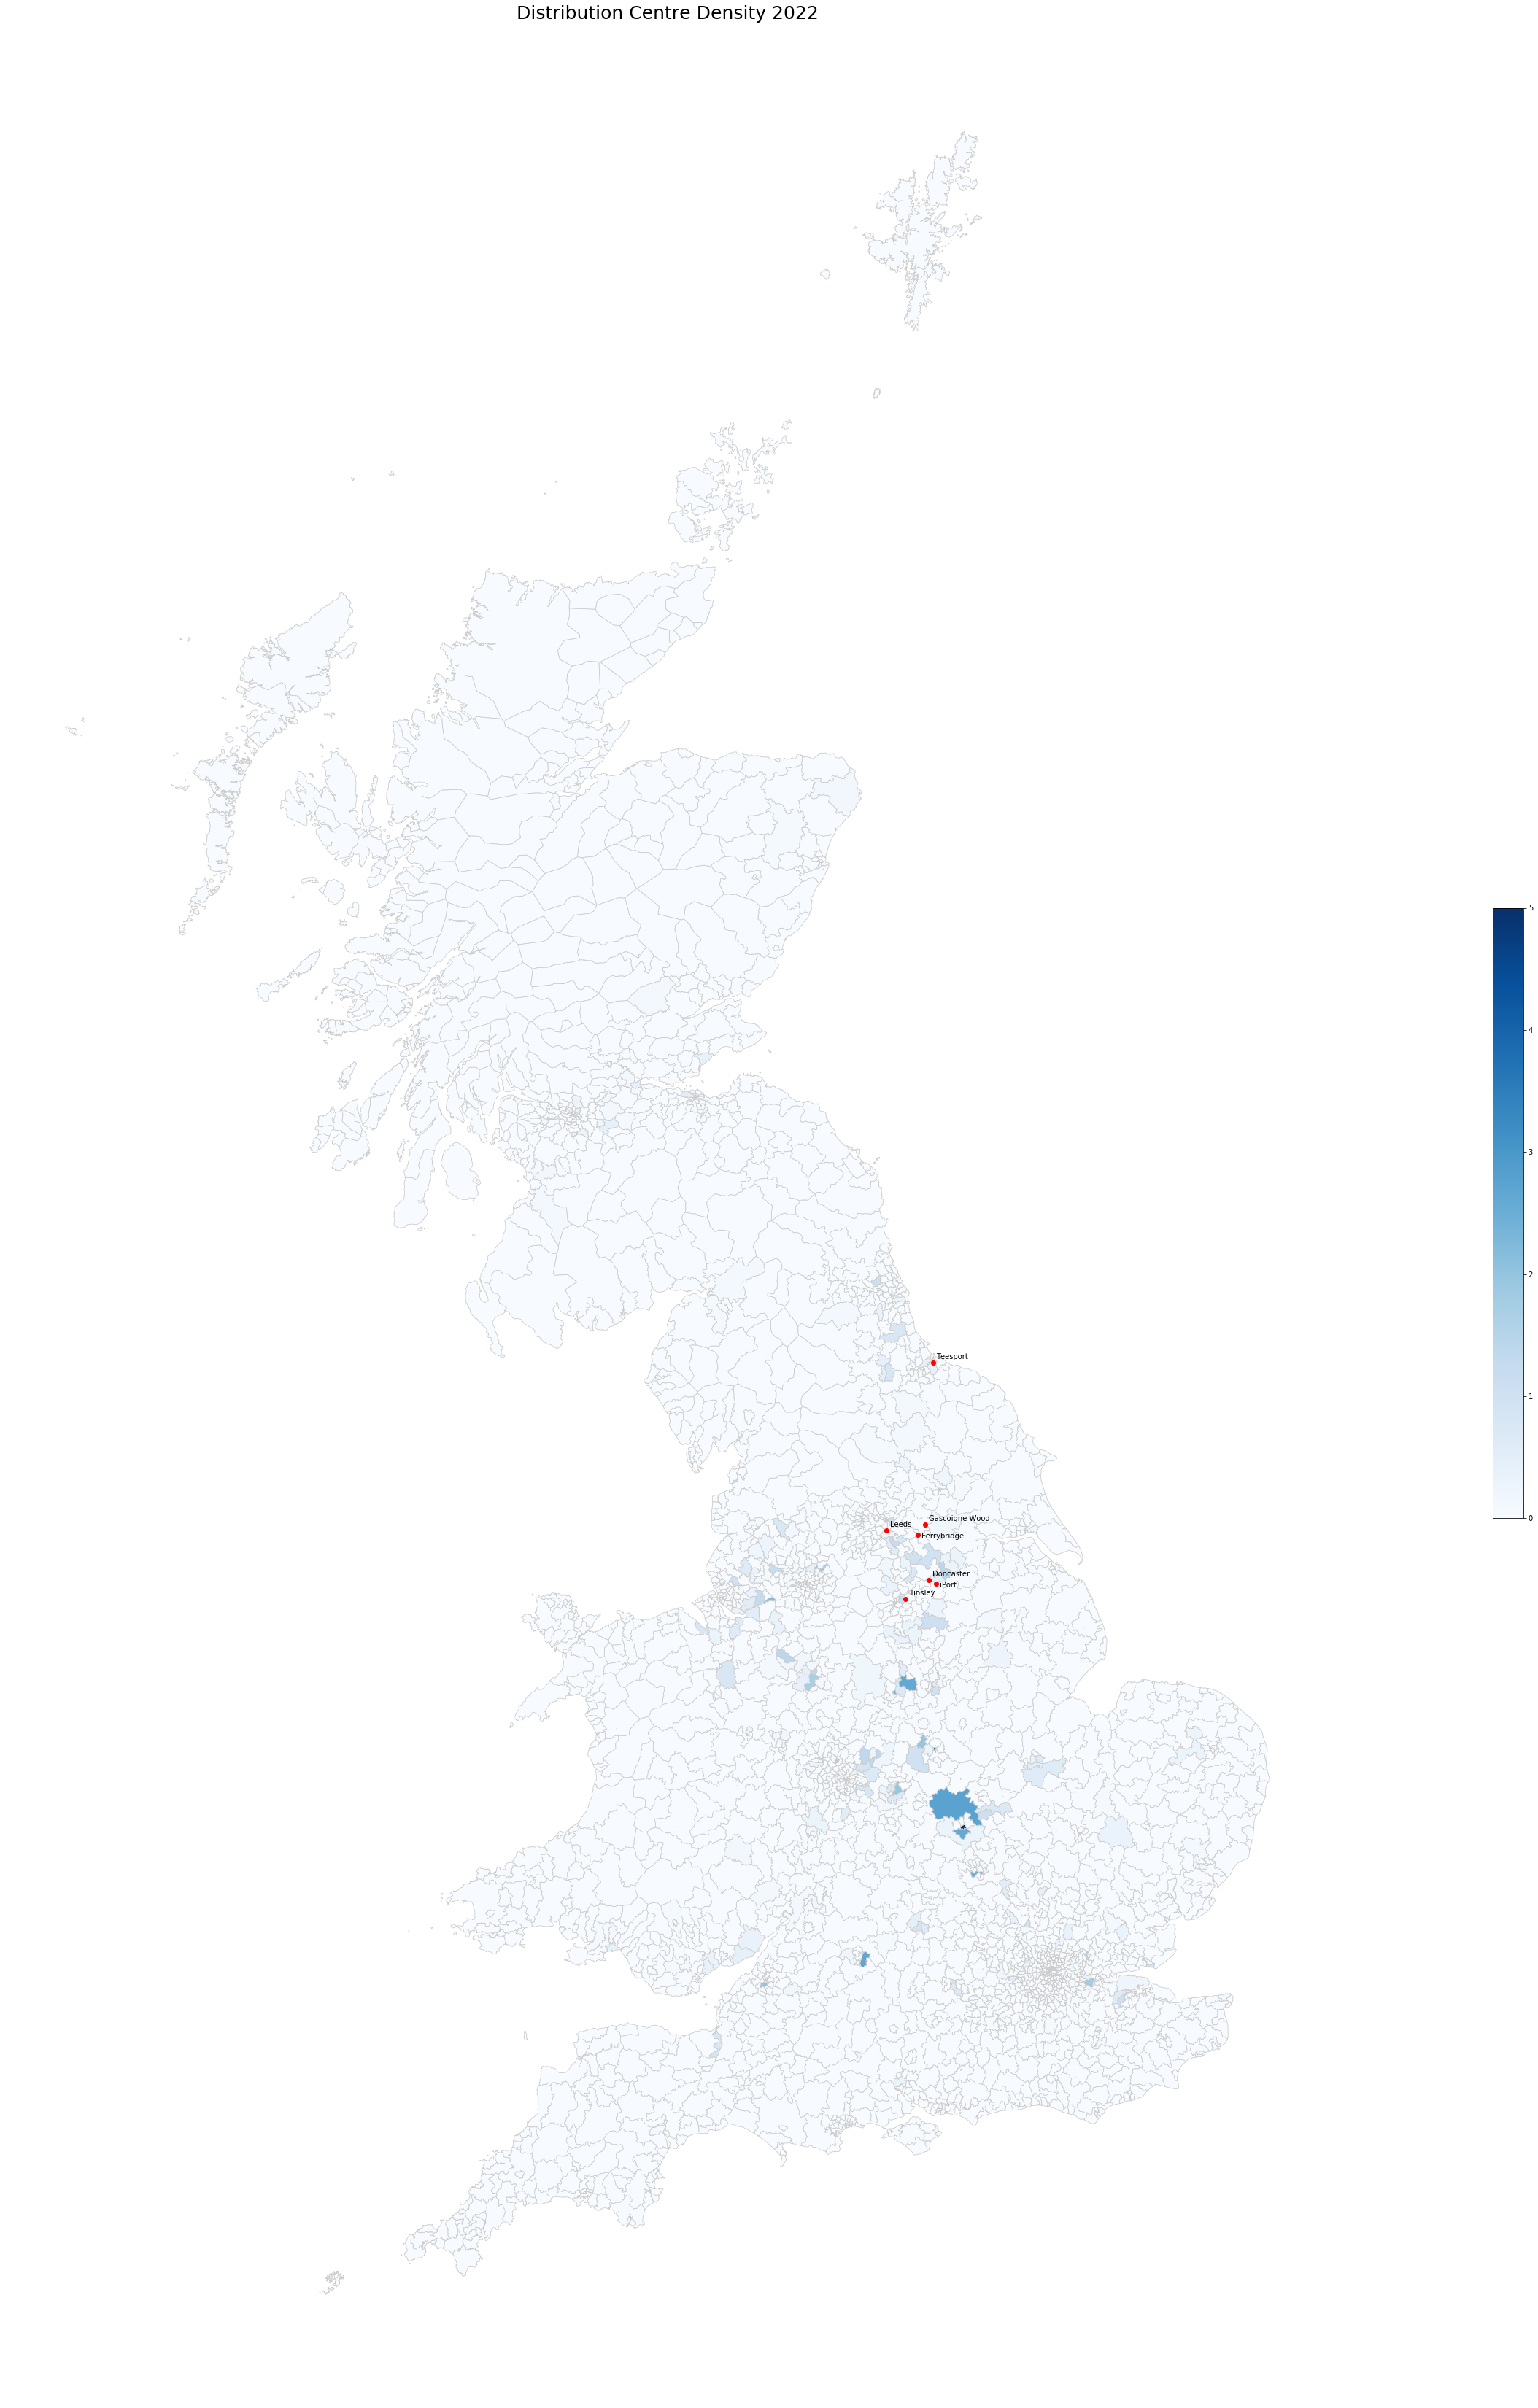

In [13]:
variable = "sf_occupied_million"
vmin, vmax = 0, 5
fig, ax = plt.subplots(1, figsize=(100, 60))

# add a title and remove axis
ax.set_title("Distribution Centre Density 2022", fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.axis('off')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, fraction=0.0075, pad=0.04)


ax.annotate("Leeds", (indexed_all_points.loc["Leeds"]["Long"], indexed_all_points.loc["Leeds"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax.annotate("Doncaster", (indexed_all_points.loc["Doncaster"]["Long"], indexed_all_points.loc["Doncaster"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax.annotate("Teesport", (indexed_all_points.loc["Teesport"]["Long"], indexed_all_points.loc["Teesport"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax.annotate("iPort", (indexed_all_points.loc["iPort"]["Long"], indexed_all_points.loc["iPort"]["Lat"]), xycoords='data', xytext=(5,-5), textcoords="offset points")
ax.annotate("Gascoigne Wood", (indexed_all_points.loc["Gascoigne Wood"]["Long"], indexed_all_points.loc["Gascoigne Wood"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax.annotate("Tinsley", (indexed_all_points.loc["Tinsley"]["Long"], indexed_all_points.loc["Tinsley"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax.annotate("Ferrybridge", (indexed_all_points.loc["Ferrybridge"]["Long"], indexed_all_points.loc["Ferrybridge"]["Lat"]), xycoords='data', xytext=(5,-5), textcoords="offset points")

merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
all_points.plot(ax=ax, color="red")

# Postcode Area-level analysis (e.g., LN)

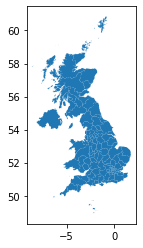

In [14]:
#Load and check map of PostCode Districts
fp_areas = "postcodes/Areas.shp"
map_df_areas = gpd.read_file(fp_areas)
map_df_areas.plot()

In [15]:
# Create Column with Postcode Area (one or two letters)
area_df = slice

In [16]:
#Aggregate postcodes with total containers for the year
aggregate_area = area_df.groupby(["PostCode_Area"])["sf_occupied_million"].sum().reset_index()
aggregate_area.describe()

sf_occupied_million
count            95.000000
mean              3.832357
std               5.169912
min               0.209369
25%               0.780760
50%               1.864164
75%               4.688675
max              32.911087

In [17]:
reset_index = map_df_areas.set_index("name")
merged_area = reset_index.join(aggregate_area.set_index("PostCode_Area"))
merged_area["sf_occupied_million"] = merged_area["sf_occupied_million"].fillna(0)
merged_area

geometry  sf_occupied_million
name                                                                        
AB    POLYGON ((-2.21091 56.88580, -2.21858 56.88676...             0.638044
AL    POLYGON ((-0.37138 51.68730, -0.37227 51.68781...             2.817553
B     POLYGON ((-2.05436 52.24756, -2.05530 52.25006...            15.909133
BA    POLYGON ((-2.08430 51.31717, -2.08008 51.31421...             0.553005
BB    POLYGON ((-2.21557 53.73160, -2.21541 53.73145...             2.329861
...                                                 ...                  ...
ZE    MULTIPOLYGON (((-0.80210 60.40932, -0.80233 60...             0.000000
BT    MULTIPOLYGON (((-5.54258 54.29000, -5.54922 54...             0.000000
GY    MULTIPOLYGON (((-2.36625 49.40170, -2.36750 49...             0.000000
IM    MULTIPOLYGON (((-4.79925 54.05825, -4.79914 54...             0.000000
JE    MULTIPOLYGON (((-2.09414 48.89542, -2.09586 48...             0.000000

[124 rows x 2 columns]

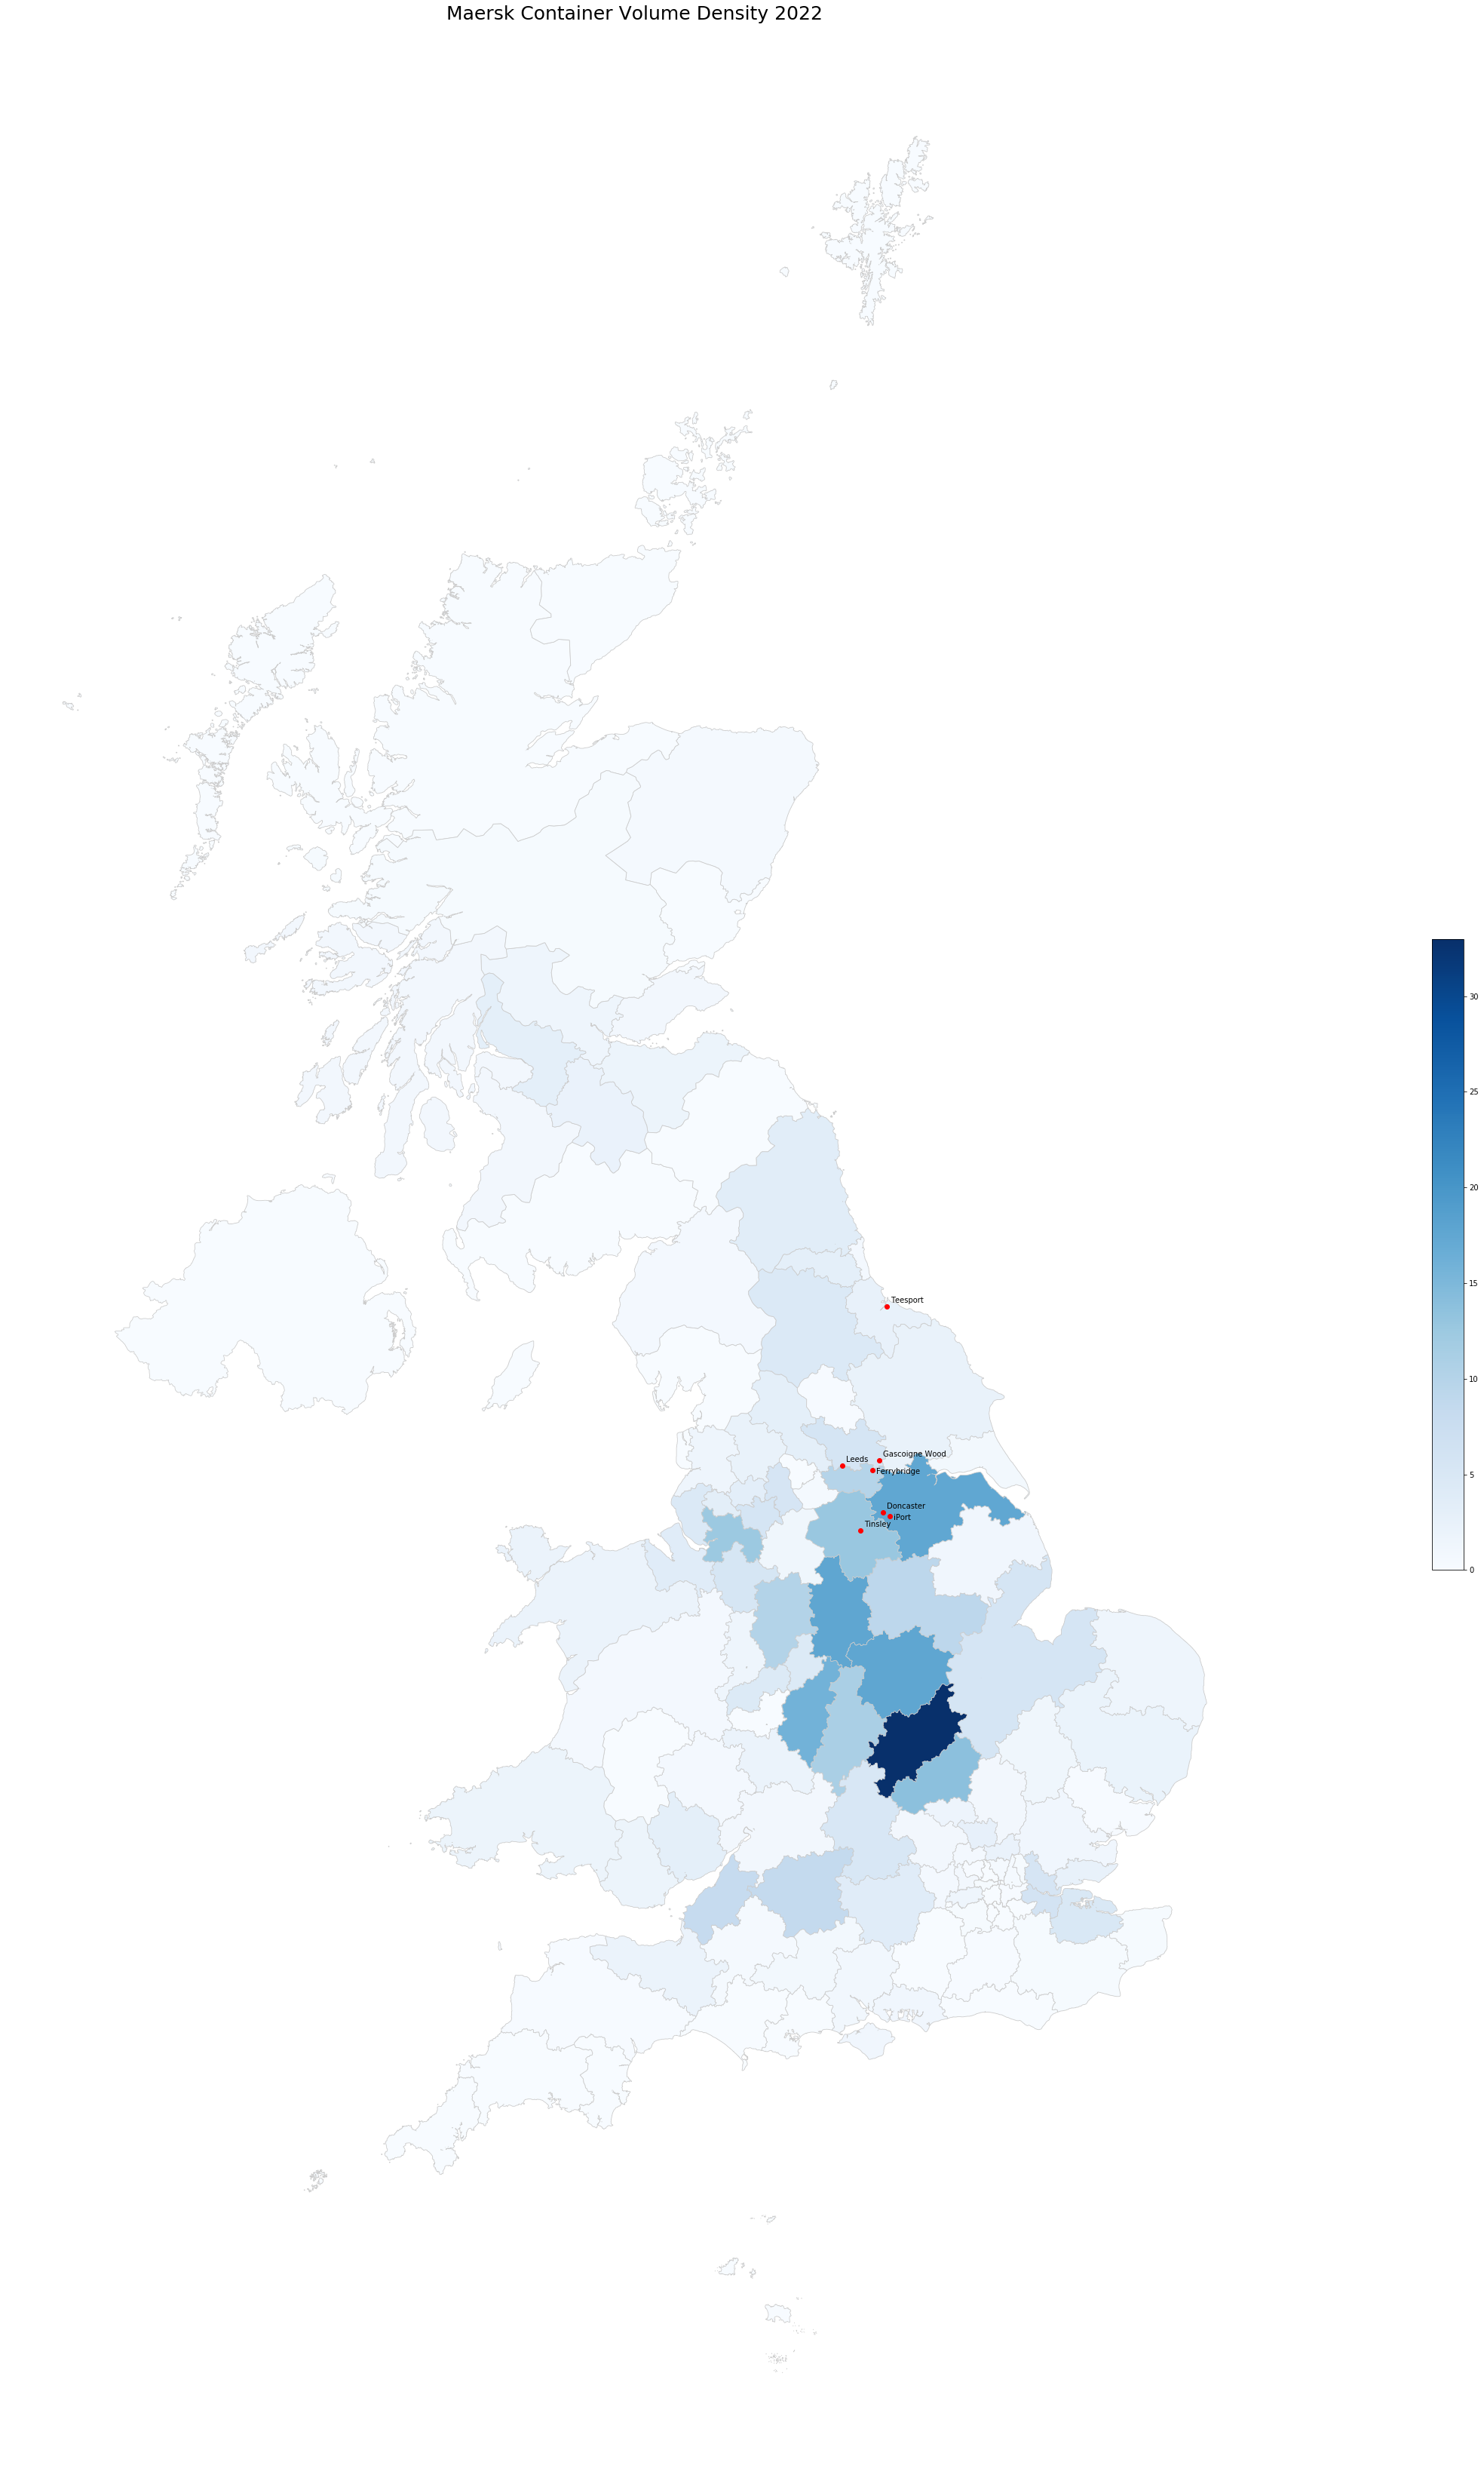

In [19]:
fig_com, ax_com = plt.subplots(1, figsize=(100, 60))
ax_com.axis('off')
vmin_area, vmax_area = 0, 33

# add a title
ax_com.set_title("Maersk Container Volume Density 2022", fontdict={'fontsize': '25', 'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin_area, vmax=vmax_area))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig_com.colorbar(sm, fraction=0.0075, pad=0.04)

ax_com.annotate("Leeds", (indexed_fl_points.loc["Leeds"]["Long"], indexed_fl_points.loc["Leeds"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax_com.annotate("Doncaster", (indexed_fl_points.loc["Doncaster"]["Long"], indexed_fl_points.loc["Doncaster"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax_com.annotate("Teesport", (indexed_all_points.loc["Teesport"]["Long"], indexed_all_points.loc["Teesport"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax_com.annotate("iPort", (indexed_all_points.loc["iPort"]["Long"], indexed_all_points.loc["iPort"]["Lat"]), xycoords='data', xytext=(5,-5), textcoords="offset points")
ax_com.annotate("Gascoigne Wood", (indexed_all_points.loc["Gascoigne Wood"]["Long"], indexed_all_points.loc["Gascoigne Wood"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax_com.annotate("Tinsley", (indexed_all_points.loc["Tinsley"]["Long"], indexed_all_points.loc["Tinsley"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax_com.annotate("Ferrybridge", (indexed_all_points.loc["Ferrybridge"]["Long"], indexed_all_points.loc["Ferrybridge"]["Lat"]), xycoords='data', xytext=(5,-5), textcoords="offset points")

merged_area.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax_com, edgecolor='0.8') 
all_points.plot(ax=ax_com, color="red")

In [120]:
out.get('results')[0].get('districts')
test_data = out.get('results')[0].get('districts')
test_data

[{'code': 'ls10',
  'properties': {'travel_time_all': {'min': 70,
    'max': 1037,
    'mean': 462,
    'median': 393},
   'travel_time_reachable': {'min': 70,
    'max': 1037,
    'mean': 462,
    'median': 393},
   'coverage': 100}},
 {'code': 'ls9',
  'properties': {'travel_time_all': {'min': 730,
    'max': 1439,
    'mean': 1093,
    'median': 1105},
   'travel_time_reachable': {'min': 730,
    'max': 1439,
    'mean': 1093,
    'median': 1105},
   'coverage': 100}},
 {'code': 'bd7',
  'properties': {'travel_time_all': {'min': 1676,
    'max': 2098,
    'mean': 1887,
    'median': 1889},
   'travel_time_reachable': {'min': 1676,
    'max': 1800,
    'mean': 1757,
    'median': 1767},
   'coverage': 20.3551912568306}},
 {'code': 'ls14',
  'properties': {'travel_time_all': {'min': 1368,
    'max': 2085,
    'mean': 1758,
    'median': 1757},
   'travel_time_reachable': {'min': 1368,
    'max': 1800,
    'mean': 1688,
    'median': 1697},
   'coverage': 62.61585993820803}},
 {'code':

In [123]:
pcarea_tt = []
mean_tt = []
for pcarea in test_data:
    pcarea_tt.append(pcarea.get('code'))
    mean_tt.append(pcarea.get('properties').get('travel_time_all').get('mean'))
    
leeds_tt = pd.DataFrame(list(zip(pcarea_tt, mean_tt)),
               columns =['pc_area', 'mean_tt'])
leeds_tt['pc_area'] = leeds_tt['pc_area'].str.upper()
leeds_tt


pc_area  mean_tt
0     LS10      462
1      LS9     1093
2      BD7     1887
3     LS14     1758
4     WF90     1586
5     BD11     1210
6      WF1     1312
7     WF13     1522
8      WF7     1936
9      LS5     1563
10    LS28     1545
11     BD3     1863
12     LS1     1074
13    LS13     1458
14    WF11     1800
15    LS27      958
16     LS4     1296
17    LS17     1907
18     HD6     1647
19    LS23     1994
20     WF6     1464
21     HD5     1974
22    LS26     1094
23     HX3     1906
24    BD19     1359
25     BD4     1556
26    WF16     1592
27    WF12     1508
28     LS8     1533
29     WF8     1829
30    LS11      704
31     LS3     1023
32     HD3     1827
33    WF10     1620
34     LS7     1303
35     WF5     1316
36    WF15     1632
37    LS16     1885
38     WF3      768
39     BD5     1653
40     S75     1834
41    LS25     1703
42     WF4     1732
43    LS12     1038
44    BD12     1436
45     HX5     1851
46     HD2     1806
47    WF14     1648
48    LS98      832
49     LS2     1059
50    WF17     1278
51     LS6     1352
52     WF2     1393
53    LS15     1541
54     BD6     1601

In [102]:
grep = slice


Line                  Corp Name               Company Name  \
0     400                4PX Express             4PX Express UK   
1     572                4PX Express                4PX Express   
2     359      4PX Express UK Co Ltd      4PX Express UK Co Ltd   
3      94     A Steadman and Son Ltd     A Steadman and Son Ltd   
4     894  A.F.Blakemore and Son Ltd  A.F.Blakemore and Son Ltd   
..    ...                        ...                        ...   
901   461            Yusen Logistics            Yusen Logistics   
902   536            Yusen Logistics            Yusen Logistics   
903   578            Yusen Logistics            Yusen Logistics   
904   579            Yusen Logistics            Yusen Logistics   
905   137                 Zooplus AG                 Zooplus AG   

    Initial Target            Building Name        Address            City  \
0              NaN            Dunstable 240    Arenson Way       Dunstable   
1              NaN          Northampton 250      Weedon Rd     Northampton   
2              NaN            Leicester 335   Leicester Ln       Leicester   
3              NaN                Steadmans         Wanell        Carlisle   
4              NaN  A F Blakemore & Son Ltd       Longacre      Willenhall   
..             ...                      ...            ...             ...   
901            3PL             NYK Building  Bradbourne Dr   Milton Keynes   
902            3PL                      NaN     Cheaney Dr     Northampton   
903            3PL          Yusen Logistics  Rutherford Dr  Wellingborough   
904            3PL          Yusen Logistics      Sywell Rd  Wellingborough   
905            NaN               Carbon 207      Siskin Dr        Coventry   

              Region  PostCode PostCode_District  ... SFO Category  \
0    East of England   LU5 4SB               LU5  ...      200-500   
1      East Midlands   NN7 3NF               NN7  ...      200-500   
2      East Midlands  LE19 1SA               LE1  ...      200-500   
3         North West   CA5 7HH               CA5  ...      200-500   
4      West Midlands  WV13 2JP               WV1  ...      200-500   
..               ...       ...               ...  ...          ...   
901       South East   MK7 8BN               MK7  ...      200-500   
902    East Midlands   NN4 5FB               NN4  ...      200-500   
903    East Midlands   NN8 6AQ               NN8  ...      200-500   
904    East Midlands   NN8 6BS               NN8  ...      200-500   
905    West Midlands   CV3 4FJ               CV3  ...      200-500   

    Bldg Size (k sq ft) SFO = Bldg # Emp  \
0             200-249.9        Yes     0   
1             200-249.9        Yes     0   
2          250 to 499.9        Yes     0   
3             200-249.9        Yes     0   
4             200-249.9        Yes     0   
..                  ...        ...   ...   
901        250 to 499.9        Yes     0   
902           200-249.9        Yes   200   
903        250 to 499.9        Yes   150   
904        250 to 499.9        Yes     0   
905           200-249.9        Yes     0   

                                        Industry Type  \
0    Professional, Scientific, and Technical Services   
1                      Transportation and Warehousing   
2                      Transportation and Warehousing   
3                                       Manufacturing   
4                                                 NaN   
..                                                ...   
901                    Transportation and Warehousing   
902  Professional, Scientific, and Technical Services   
903                    Transportation and Warehousing   
904                    Transportation and Warehousing   
905                                          Retailer   

                     Location                  Submarket  \
0            Main HQ Corp/LLC      West Bedfordshire Ind   
1             Single Location  Northamptonshire South In   
2                         Na